In [ ]:
# === SSC bootstrap cell (no borrar) ===
import os, sys, pathlib
BASE = "/content/drive/MyDrive/SSC"
os.environ["SSC_ROOT"] = BASE
os.environ["SSC_CACHE_DIR"] = f"{BASE}/.ssc_cache"
pathlib.Path(os.environ["SSC_CACHE_DIR"]).mkdir(parents=True, exist_ok=True)
sys.path.insert(0, BASE)

from ssc_pipeline.ssc_pipeline import run as ssc_update
ssc_update()  # refresca /content/drive/MyDrive/SSC/main.csv

import pandas as pd
df = pd.read_csv(f"{BASE}/main.csv")
print("main.csv cargado desde:", f"{BASE}/main.csv", "| Filas:", len(df))
df.head(3)


In [3]:
import re
import os
import time
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Table of Contents

1. Background Information and Introduction  
   1.1. What are Tariffs?  
   1.2. President Donald Trump’s Current Tariff Plans  
   1.3. Problem Statement

# Background Information and Introduction

## What are Tariffs?

Tariffs have been historically used by U.S. foreign policy to protect domestic industries from numerous factors such as foreign competition and trade imbalances, and they can also help generate more government revenue (YouTube). Despite these benefits however, the effectiveness and consequences of tariffs remain widely debated, with opponents of such policies emphasizing that reliance on tariffs often lead to higher costs for domestic businesses and consumers, disrupt global supply chains, and trigger retaliatory measures from trading partners (Krugman & Obstfeld, 2021). While tariffs can be an effective tool for protecting domestic production, they also “increase the cost of imports, which can lead to higher prices for consumers” (Hersh & Bivens 2025)  and create additional economic challenges for businesses reliant on foreign supply chains.

## President Donald Trump’s Current Tariff Plans

As President Trump retakes office for his second term, the topic of tariffs has been rejuvenated, as he has vowed to impose heavy taxes on many foreign nations, including a 60% tariff on Chinese imports and a 200% tariff on some foreign automobiles (Chu 2025). While the Trump administration claims that these tariffs are intended to enrich American citizens (The United States Government 2025) by increasing domestic production and address trade imbalances, the EPI highlights that tariffs can have counterintuitive effects, noting that “large, broad-based tariffs can put upward pressure on the value of the U.S. dollar, making American goods more expensive to foreign buyers” (Hersh & Bivens 2025). This would ultimately negate the intended economic benefits, placing the burden on domestic businesses and consumers.

## Problem Statement

The objective of this study is to evaluate how tariffs affect trade, production costs, consumer prices, and overall economic stability by drawing insights from past tariffs and simulating potential outcomes of current tariff proposals. By analyzing historical data and simulating potential outcomes of current tariff proposals, we aim to provide a comprehensive assessment of tariff policies and their consequences.

Our study is centered around two primary questions:

1. Do the tariffs proposed by the Trump Administration align with their intended economic objectives or risk harming the very industries and consumers they aim to protect?

2. What consequences, if any, may result from these tariffs — from American households to global supply networks?



# Data Preparation

## Web Scraping

The code snippet shown below is responsible for retrieving and organizing annual U.S. trade data (imports and exports) from the World Bank’s WITS portal for the years 2000–2022. The script iterates through each year in the specified range and constructs a dataframe/CSV file containing trade data between the United States and every one of its trade partners (around 220 countries).

In [5]:
year_data = {}
for year in range(2000, 2023):

    # Get the HTML response from the webpage
    time.sleep(0.05)
    response = requests.get(f"https://wits.worldbank.org/CountryProfile/en/Country/USA/Year/{year}/TradeFlow/EXPIMP/Partner/by-country#")

    # Extract the JavaScript table data
    soup = BeautifulSoup(response.text, "html.parser")
    script_tags = soup.find_all("script", string=re.compile(r'var col\d+ ='))

    # Get the script content
    data, columns = {}, []; script_content = script_tags[0].string

    # Extract columns (col0, col1, etc.)
    for col_match in re.finditer(r"var (col\d+) =\s+\[([^\]]+)\];", script_content):
        col_name = col_match.group(1)  # e.g., col0, col1
        col_data = eval(col_match.group(2))  # Convert array string to Python list
        data[col_name] = col_data; columns.append(col_name)

    # Extract column headers
    headers_match = re.search(r"columns: \[\{ text:'([^']+)", script_content); headers = []
    if headers_match: headers = [header.group(1) for header in re.finditer(r"text:'([^']+)", script_content)]
    if not headers: headers = [f"Column {i}" for i in range(len(columns))]

    # Convert to DataFrame and save to dictionary and file storage
    df = pd.DataFrame(data).rename(columns={f"col{i}": headers[i] for i in range(len(headers))})
    year_data[year] = df;

We can better understand the features of this data by running `year_data[2022]`.

In [6]:
year_data[2022].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Partner Name                             223 non-null    object
 1   No Of exported HS6 digit Products        223 non-null    object
 2   No Of imported HS6 digit Products        223 non-null    object
 3   Export Share in Total Products (%)       223 non-null    object
 4   Import Share in Total Products (%)       223 non-null    object
 5   Trade Balance (US$ Thousand)             223 non-null    object
 6   Export (US$ Thousand)                    223 non-null    object
 7   Import (US$ Thousand)                    223 non-null    object
 8   Import Partner Share (%)                 223 non-null    object
 9   Export Partner Share (%)                 223 non-null    object
 10  AHS Simple Average (%)                   223 non-null    objec

Based on the information above, we can derive information about both trade volume and tariff structure. For instance, `Partner Name`, `Export (US$ Thousand)`, and `Import (US$ Thousand)` reveal the bilateral flow of goods with each trading partner. Columns like `MFN MaxRate (%)` and `MFN MinRate (%)` detail the tariff range imposed under Most Favored Nation conditions, offering insight into potential cost barriers for certain products.

While this data does give a good overview of trade flow, it does not provide any detailed composition for each particular nation. To overcome this, we scrape more data containing the product composition for the top trade partners as shown in the code cell below.

In [7]:
countries = {'China': 'CHN', 'Canada': 'CAN', 'Germany': 'DEU', 'Japan': 'JPN', 'Mexico': 'MEX'}
main_df = pd.DataFrame()
for country in list(countries.keys()):

  # Loop through the years from 1991 to 2022s
  for year in range(2000, 2023):

    # Get the response for the specific year
    time.sleep(0.05)
    response = requests.get(f"https://wits.worldbank.org/CountryProfile/en/Country/USA/Year/{year}/TradeFlow/EXPIMP/Partner/{countries[country]}/Product/all-groups")

    # Extract the JavaScript table data
    soup = BeautifulSoup(response.text, "html.parser");
    script_tags = soup.find_all('script', string=re.compile(r'var col\d+ ='))
    if not script_tags: continue

    # Get the script content
    data, columns = {}, [];  script_content = script_tags[0].string

    # Extract column daata
    for col_match in re.finditer(r"var (col\d+) =\s+\[([^\]]+)\];", script_content):
        col_name = col_match.group(1)  # Column name (e.g., col0, col1)
        col_data = eval(col_match.group(2))  # Convert array string to Python list
        data[col_name] = col_data; columns.append(col_name)

    # Extract column headers from another script variable, if available
    headers_match = re.search(r"columns: \[\{ text:'([^']+)", script_content);  headers = []
    if headers_match:  headers = [header.group(1) for header in re.finditer(r"text:'([^']+)", script_content)]
    if not headers: headers = [f"Column {i}" for i in range(len(columns))]

    # Create df for the current year and save to data structure and file storage
    df = pd.DataFrame(data).rename(columns={f"col{i}": headers[i] for i in range(len(headers))})
    # df.to_csv(f"{countries_dir}{country}/{year}.csv", index = False)
    # df.to_csv(f"{years_dir}{year}/{country}.csv", index = False)
    df['Country'], df['Year'] = country, year; main_df = pd.concat([main_df, df], ignore_index = True)

In [8]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2415 entries, 0 to 2414
Data columns (total 34 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Product Group                            2415 non-null   object
 1   Export (US$ Thousand)                    2415 non-null   object
 2   Import (US$ Thousand)                    2415 non-null   object
 3   Export Product Share (%)                 2415 non-null   object
 4   Import Product Share (%)                 2415 non-null   object
 5   Revealed comparative advantage           2415 non-null   object
 6   World Growth (%)                         2415 non-null   object
 7   Country Growth (%)                       2415 non-null   object
 8   AHS Simple Average (%)                   2415 non-null   object
 9   AHS Weighted Average (%)                 2415 non-null   object
 10  AHS Total Tariff Lines                   2415 non-null   obj

This dataframe contains more detailed data illustrating product-specific trade data for the top five U.S. trading partners across multiple years. Columns like ``Product Group``, ``Export (US$ Thousand)``, and ``Import (US$ Thousand)`` show the category of goods traded and the corresponding monetary values. Other columns, such as ``AHS Simple Average (%)``, ``MFN Weighted Average (%)``, and ``Revealed comparative advantage``, highlight different tariff structures and the relative competitiveness of the United States in specific product groups. These features will be useful later during the simulation.

## Preprocessing

Based on `df.info()` outputs above, we can see that a lot of these columns are stored as objects when they should be numerical. This can cause performance bottlenecks during our exploratory data analysis and simulation stages. To avoid this, we should convert each column to its appropriate data type.

In [9]:
for col in main_df.columns:
    if col not in ["Product Group", "Country"]: main_df[col] = pd.to_numeric(main_df[col], errors='coerce')

for year in range(2000, 2023):
    for col in year_data[year].columns:
        if col not in ["Partner Name"]: year_data[year][col] = pd.to_numeric(year_data[year][col], errors='coerce')

Given that imports and exports between countries, especially the top trade partners of the United States, is usually in the billions, this could cause a numerical overflow in the simulation in case the forecasted values approach negative of positive infinity. To prevent this, we should standardize the data of the columns that contain monetary value from `US$ Thousand` to `US$ Billion`.

In [10]:
money_cols = [col for col in main_df.columns if "(US$ Thousand)" in col]
col_names, rename_dict = list(main_df.columns), {}
for col in money_cols:
    main_df[col] = main_df[col] / 1e6
    rename_dict[col] = col.replace("(US$ Thousand)", "(US$ Billion)")
main_df.rename(columns = rename_dict, inplace = True)

for year in range(2000, 2023):
    money_cols = [col for col in year_data[year].columns if "(US$ Thousand)" in col]
    col_names, rename_dict = list(year_data[year].columns), {}
    for col in money_cols:
        year_data[year][col] = year_data[year][col] / 1e6
        rename_dict[col] = col.replace("(US$ Thousand)", "(US$ Billion)")
    year_data[year].rename(columns = rename_dict, inplace = True)

In [11]:
main_df[['Export (US$ Billion)', 'Import (US$ Billion)']].describe()

,Export (US$ Billion),Import (US$ Billion)
count,2415.000000,2415.000000
mean,17.730409,32.851346
std,36.437654,65.306280
min,0.007872,0.011533
25%,1.488912,1.081177
50%,5.870805,8.066105
75%,16.769296,33.174270
max,354.887051,575.688091


As shown in the sampled dataframe above, the values have now been standardized to reflect USD Billions. This will greatly enhance our simulation efficiency and performance since the computations will be using more regularized numbers.

# Exploratory Data Analysis

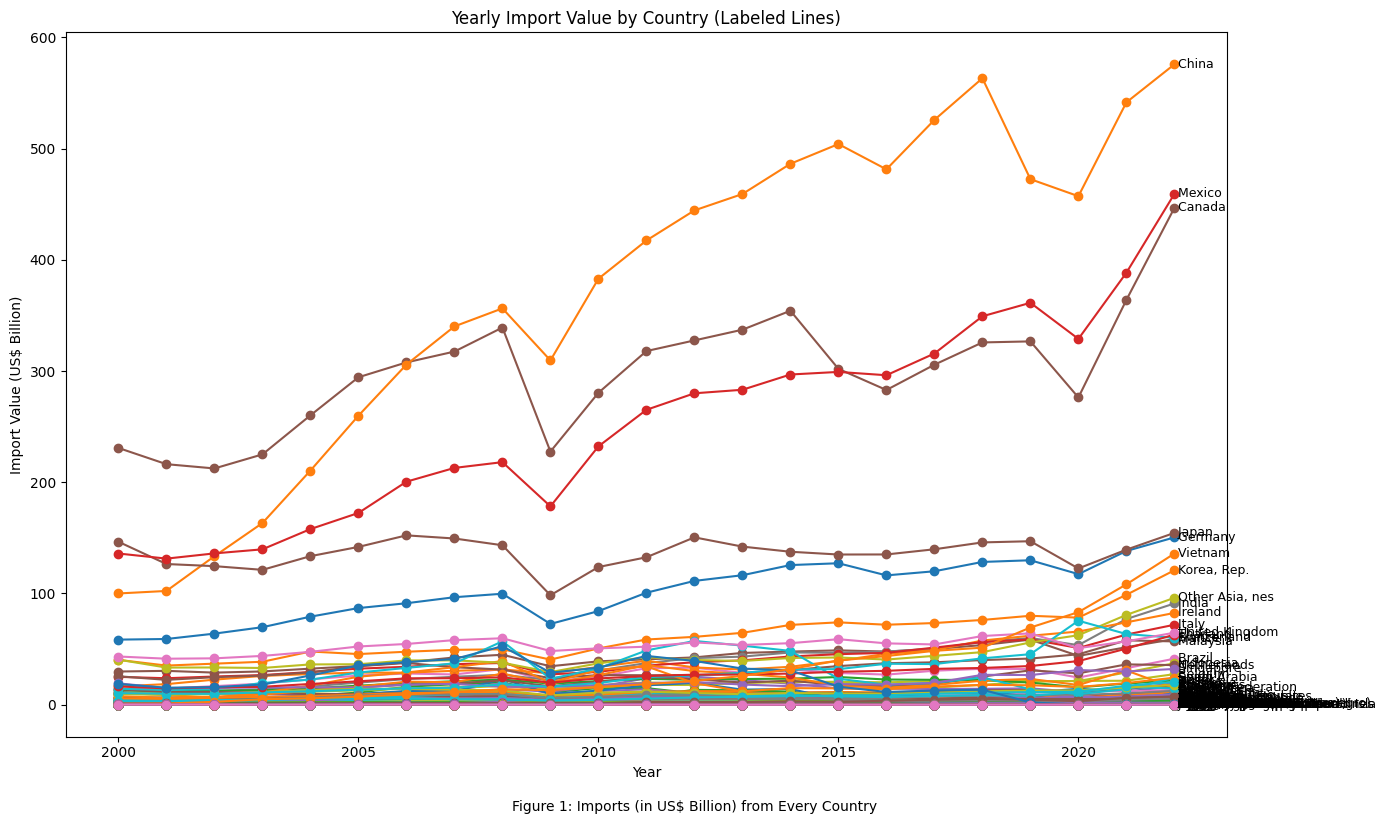

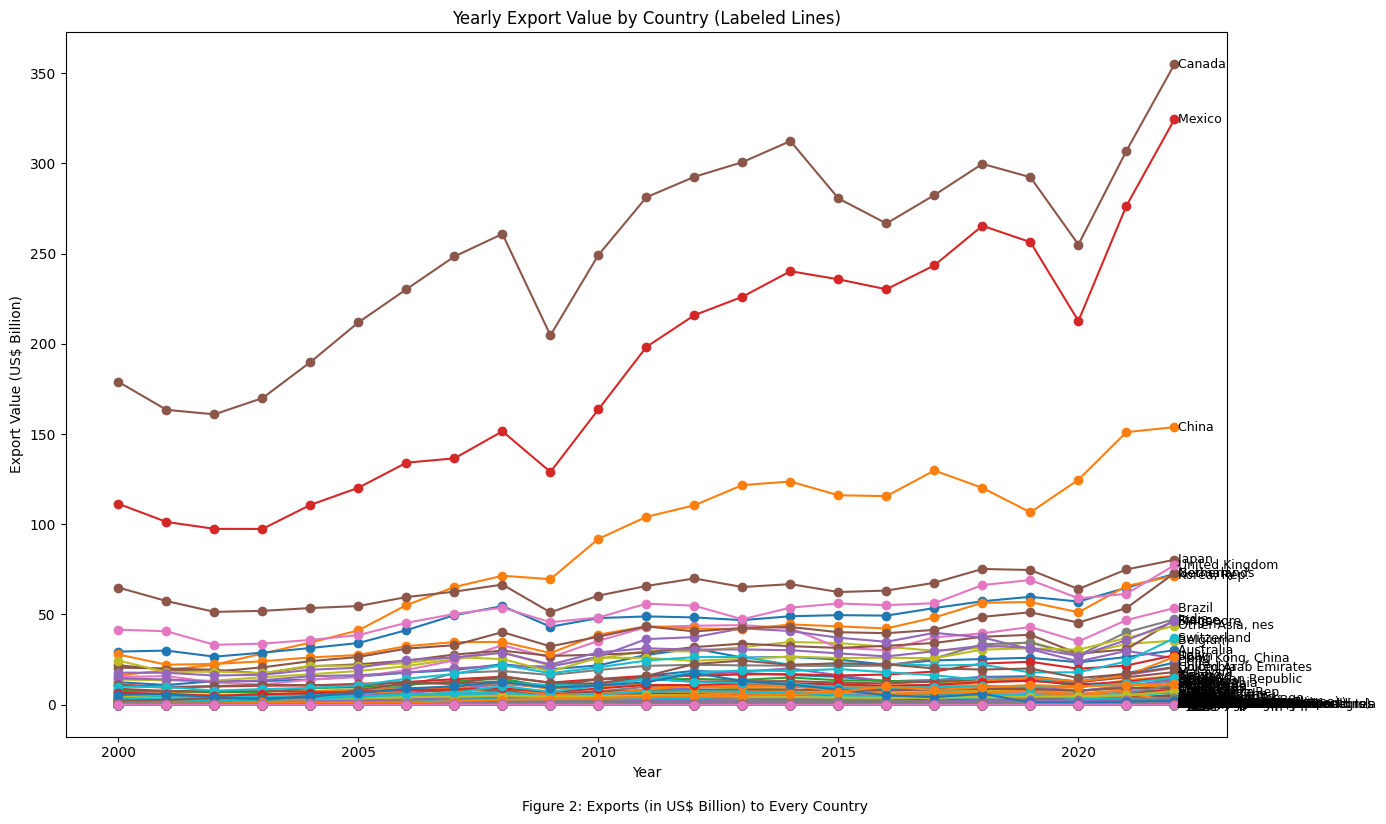

In [14]:
# Combine all yearly dataframes into one, adding a 'Year' column
all_data = []
for year, df in year_data.items():
    df_copy = df.copy()
    df_copy['Year'] = int(year)
    all_data.append(df_copy)
combined_df = pd.concat(all_data, ignore_index=True)

# Create a pivot table for imports: rows are years, columns are countries,
# and values are summed import values.
import_pivot = impexp_df.pivot_table(
    index='Year',
    columns='Partner Name',
    values='Import (US$ Billion)',
    aggfunc='sum'
)

# Create a pivot table for exports: rows are years, columns are countries,
# and values are summed export values.
export_pivot = impexp_df.pivot_table(
    index='Year',
    columns='Partner Name',
    values='Export (US$ Billion)',
    aggfunc='sum'
)

# Plotting Imports with in-graph labels
plt.figure(figsize=(14, 8))
for country in import_pivot.columns:
    plt.plot(import_pivot.index, import_pivot[country], marker='o')
    # Get the last data point for labeling
    last_year = import_pivot.index[-1]
    last_value = import_pivot[country].iloc[-1]
    plt.text(last_year, last_value, f" {country}", fontsize=9, va='center', ha='left')
plt.xlabel('Year')
plt.ylabel('Import Value (US$ Billion)')
plt.title('Yearly Import Value by Country (Labeled Lines)')
plt.figtext(0.5, -0.02, "Figure 1: Imports (in US$ Billion) from Every Country", ha='center')

plt.tight_layout()
plt.show()

# Plotting Exports with in-graph labels
plt.figure(figsize=(14, 8))
for country in export_pivot.columns:
    plt.plot(export_pivot.index, export_pivot[country], marker='o')
    # Get the last data point for labeling
    last_year = export_pivot.index[-1]
    last_value = export_pivot[country].iloc[-1]
    plt.text(last_year, last_value, f" {country}", fontsize=9, va='center', ha='left')
plt.xlabel('Year')
plt.ylabel('Export Value (US$ Billion)')
plt.title('Yearly Export Value by Country (Labeled Lines)')
plt.figtext(0.5, -0.02, "Figure 2: Exports (in US$ Billion) to Every Country", ha='center')
plt.tight_layout()
plt.show()

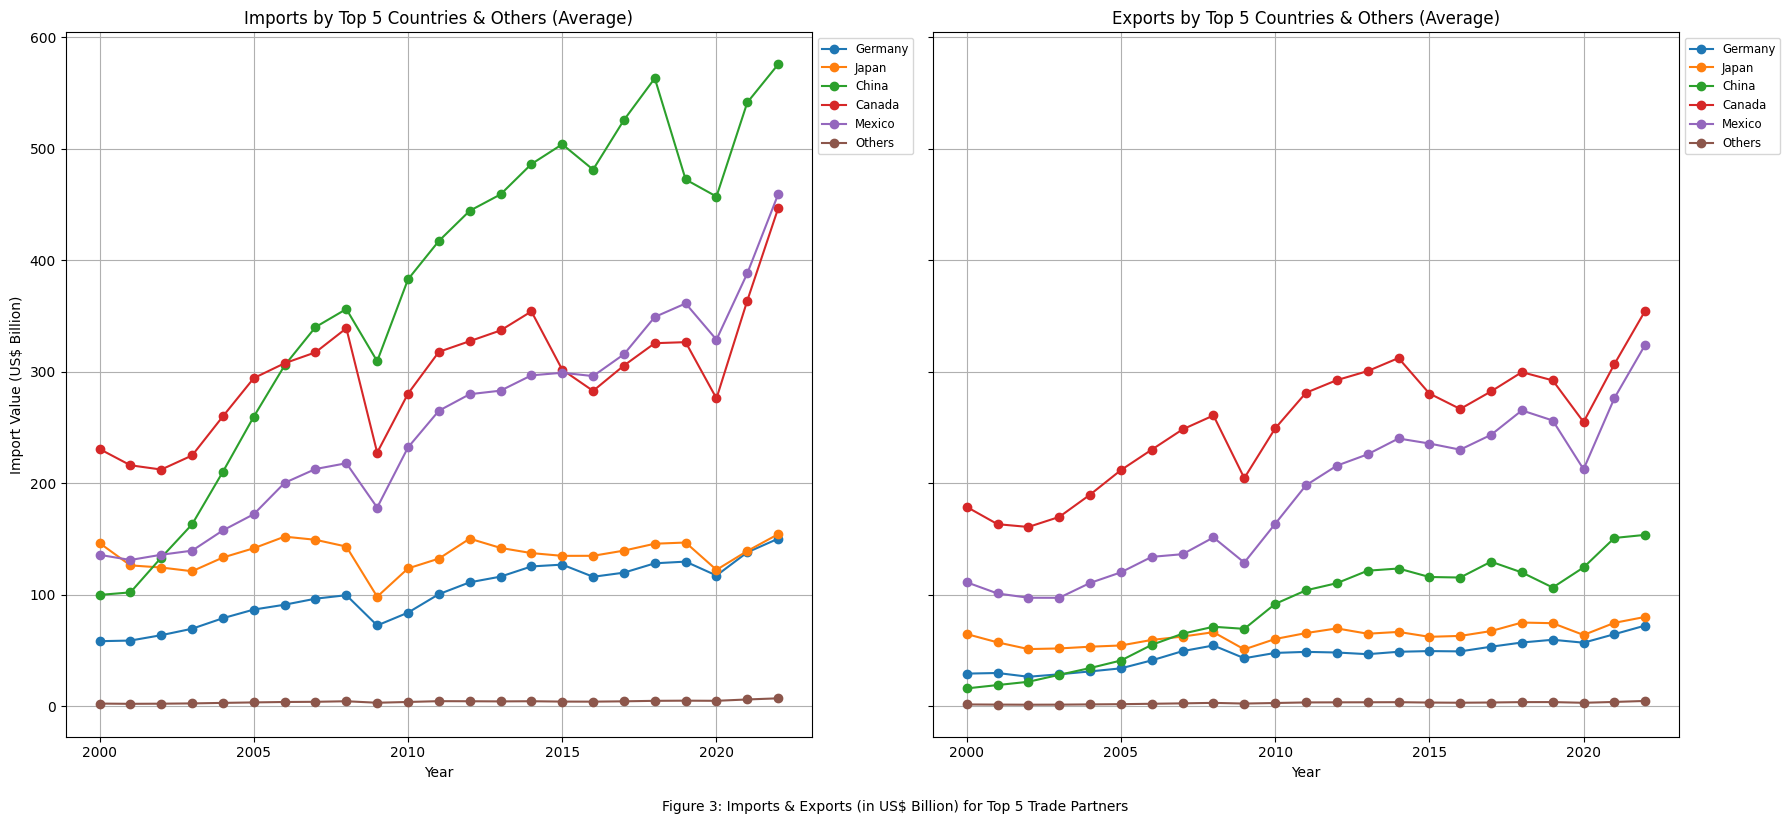

In [15]:
# Create pivot tables for imports and exports.
# Rows: Year, Columns: Partner Name, Values: sum of trade values
import_pivot = combined_df.pivot_table(
    index='Year',
    columns='Partner Name',
    values='Import (US$ Billion)',
    aggfunc='sum'
)
export_pivot = combined_df.pivot_table(
    index='Year',
    columns='Partner Name',
    values='Export (US$ Billion)',
    aggfunc='sum'
)

# Ensure the years are in order
import_pivot.sort_index(inplace=True)
export_pivot.sort_index(inplace=True)

# -----------------------------
# Define Top 5 and Compute "Others"
# -----------------------------
top5_countries = ["Germany", "Japan", "China", "Canada", "Mexico"]
others = [country for country in import_pivot.columns if country not in top5_countries]

# Compute the average import and export values for "others" by year
others_import = import_pivot[others].mean(axis=1)
others_export = export_pivot[others].mean(axis=1)

# -----------------------------
# Define a uniform color mapping
# -----------------------------
cmap = plt.get_cmap('tab10')
color_map = {}
for i, country in enumerate(top5_countries):
    color_map[country] = cmap(i)
color_map["Others"] = cmap(len(top5_countries))  # Next available color

# -----------------------------
# Plotting: Create two subplots (Imports and Exports)
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Plot Imports: use the uniform colors
for country in top5_countries:
    if country in import_pivot.columns:
        axes[0].plot(import_pivot.index, import_pivot[country],
                     marker='o', label=country, color=color_map[country])
axes[0].plot(others_import.index, others_import,
             marker='o', label="Others", color=color_map["Others"])
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Import Value (US$ Billion)")
axes[0].set_title("Imports by Top 5 Countries & Others (Average)")
axes[0].grid(True)
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

# Plot Exports: use the same uniform colors
for country in top5_countries:
    if country in export_pivot.columns:
        axes[1].plot(export_pivot.index, export_pivot[country],
                     marker='o', label=country, color=color_map[country])
axes[1].plot(others_export.index, others_export,
             marker='o', label="Others", color=color_map["Others"])
axes[1].set_xlabel("Year")
axes[1].set_title("Exports by Top 5 Countries & Others (Average)")
axes[1].grid(True)
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.figtext(0.5, -0.02, "Figure 3: Imports & Exports (in US$ Billion) for Top 5 Trade Partners", ha='center')
plt.tight_layout()
plt.show()

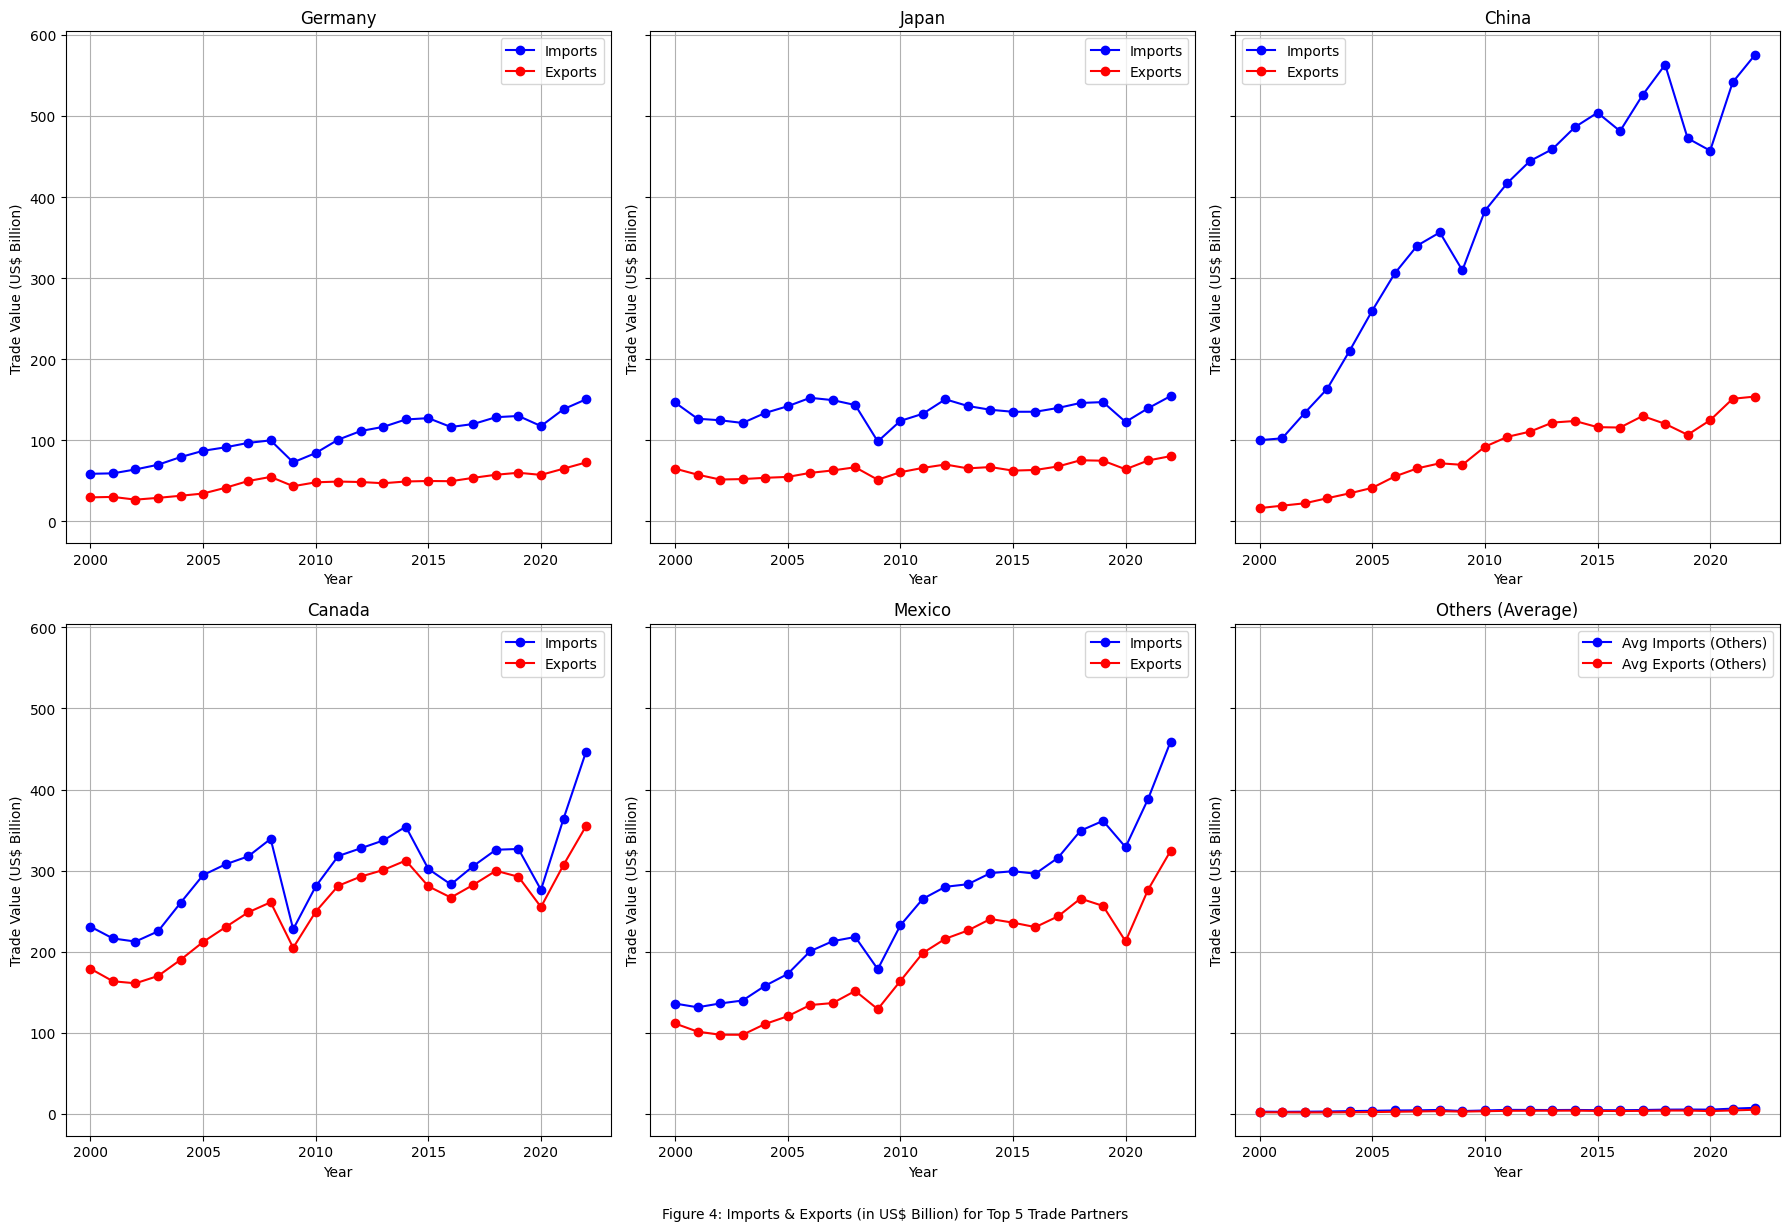

In [16]:
combined_df = impexp_df

# Create pivot tables for imports and exports.
# Rows: Year, Columns: Partner Name, Values: sum of trade values
import_pivot = combined_df.pivot_table(
    index='Year',
    columns='Partner Name',
    values='Import (US$ Billion)',
    aggfunc='sum'
)
export_pivot = combined_df.pivot_table(
    index='Year',
    columns='Partner Name',
    values='Export (US$ Billion)',
    aggfunc='sum'
)

# Ensure the years are in order
import_pivot.sort_index(inplace=True)
export_pivot.sort_index(inplace=True)

# -----------------------------
# Compute series for "Others"
# -----------------------------
# Define the top trade partners
top5_countries = ["Germany", "Japan", "China", "Canada", "Mexico"]
# Get all other countries (those not in the top 5)
others = [country for country in import_pivot.columns if country not in top5_countries]

# Compute the average import and export values for these other countries by year
others_import = import_pivot[others].mean(axis=1)
others_export = export_pivot[others].mean(axis=1)

# -----------------------------
# Plotting: Create a 3x2 grid of subplots
# -----------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
axes = axes.flatten()  # Flatten to simplify indexing

# Plot each of the top 5 countries in its own subplot
for i, country in enumerate(top5_countries):
    ax = axes[i]
    # Plot imports (blue) if data is available
    if country in import_pivot.columns:
        ax.plot(import_pivot.index, import_pivot[country], color='blue', marker='o', label='Imports')
    # Plot exports (red) if data is available
    if country in export_pivot.columns:
        ax.plot(export_pivot.index, export_pivot[country], color='red', marker='o', label='Exports')
    ax.set_title(country)
    ax.set_xlabel("Year")
    ax.set_ylabel("Trade Value (US$ Billion)")
    ax.legend()
    ax.grid(True)  # Add grid lines

# Plot the averaged "Others" in the 6th subplot
ax = axes[-1]
ax.plot(others_import.index, others_import, color='blue', marker='o', label='Avg Imports (Others)')
ax.plot(others_export.index, others_export, color='red', marker='o', label='Avg Exports (Others)')
ax.set_title("Others (Average)")
ax.set_xlabel("Year")
ax.set_ylabel("Trade Value (US$ Billion)")
ax.legend()
ax.grid(True)  # Add grid lines
plt.figtext(0.5, -0.02, "Figure 4: Imports & Exports (in US$ Billion) for Top 5 Trade Partners", ha='center')
plt.tight_layout()
plt.show()

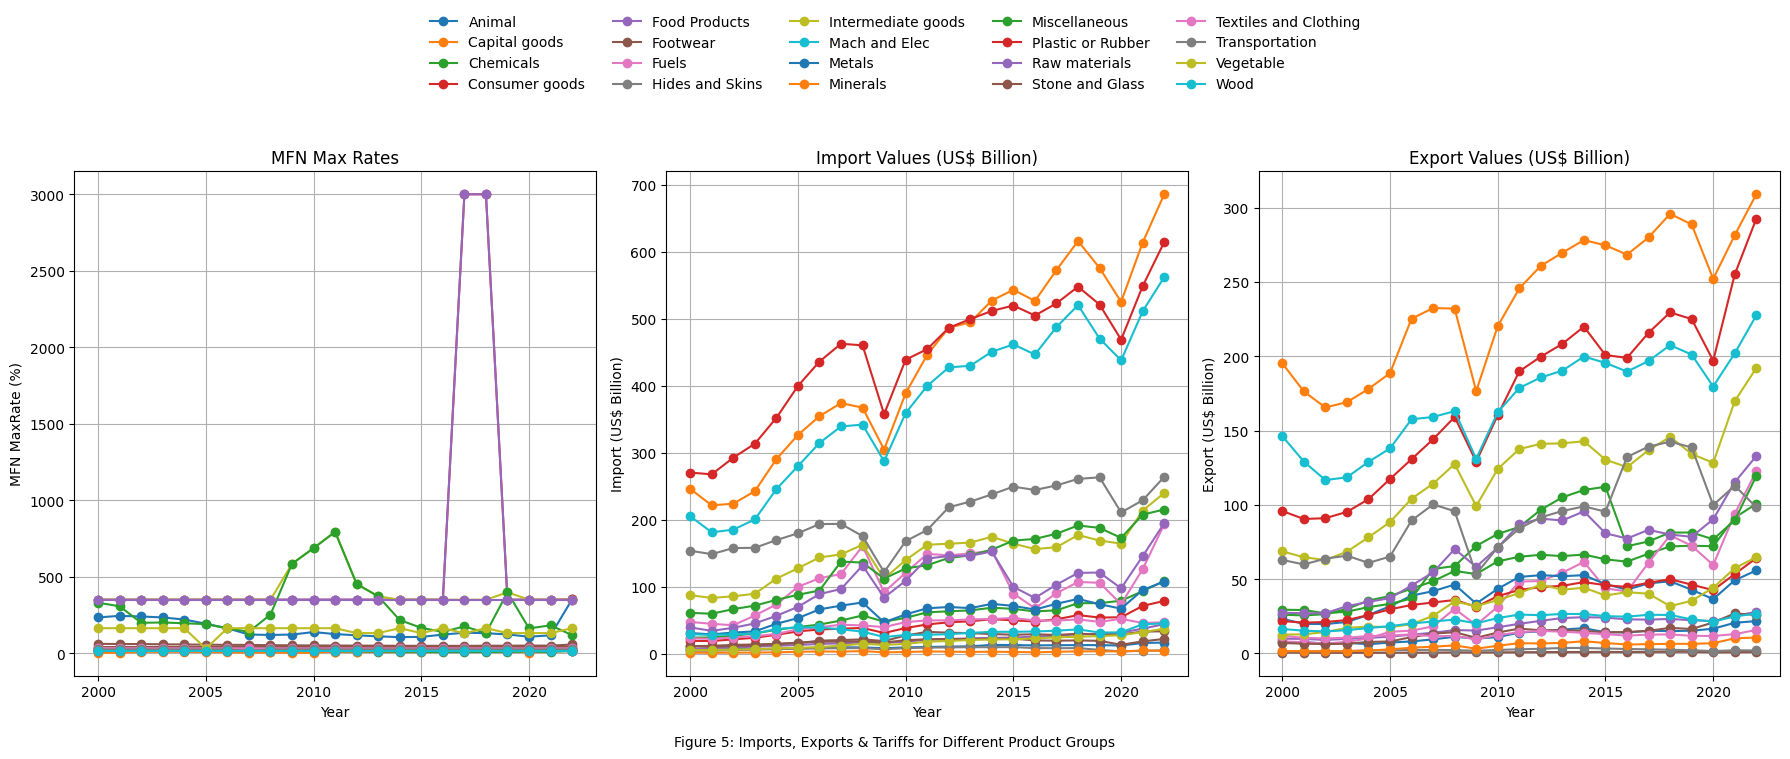

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Pivot for MFN Max Rates
# If multiple rows exist per Year-ProductGroup, we take the maximum of MFN MaxRate.
df_mfn = main_df.pivot_table(
    index='Year',
    columns='Product Group',
    values='MFN MaxRate (%)',
    aggfunc='max'
)
df_mfn.sort_index(inplace=True)
df_mfn = df_mfn.drop('All Products', axis=1)

# Pivot for Imports (summing any duplicates by Year-ProductGroup)
df_import = main_df.pivot_table(
    index='Year',
    columns='Product Group',
    values='Import (US$ Billion)',
    aggfunc='sum'
)
df_import.sort_index(inplace=True)
df_import = df_import.drop('All Products', axis=1)

# Pivot for Exports (summing any duplicates by Year-ProductGroup)
df_export = main_df.pivot_table(
    index='Year',
    columns='Product Group',
    values='Export (US$ Billion)',
    aggfunc='sum'
)
df_export.sort_index(inplace=True)
df_export = df_export.drop('All Products', axis=1)


# Create a 1x3 grid of subplots, sharing the x-axis
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Titles for each subplot
axes[0].set_title("MFN Max Rates")
axes[1].set_title("Import Values (US$ Billion)")
axes[2].set_title("Export Values (US$ Billion)")

# Plot each Product Group as a separate line in all three subplots
for product_group in df_mfn.columns:
    # MFN Max Rates
    axes[0].plot(
        df_mfn.index,
        df_mfn[product_group],
        label=product_group,
        marker = 'o'
    )
    # Import Values
    axes[1].plot(
        df_import.index,
        df_import[product_group],
        label=product_group,
        marker = 'o'
    )
    # Export Values
    axes[2].plot(
        df_export.index,
        df_export[product_group],
        label=product_group,
        marker = 'o'
    )

# Set x-axis and y-axis labels
axes[0].set_xlabel("Year")
axes[1].set_xlabel("Year")
axes[2].set_xlabel("Year")

axes[0].set_ylabel("MFN MaxRate (%)")
axes[1].set_ylabel("Import (US$ Billion)")
axes[2].set_ylabel("Export (US$ Billion)")\

for i in range(3): axes[i].grid(True)

# Extract legend handles/labels from one subplot (they are the same across all)
handles, labels = axes[0].get_legend_handles_labels()

# Place a single legend at the top center (adjust as needed)
fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=5,  # Increase/decrease for layout
    frameon=False
)
plt.figtext(0.5, -0.02, "Figure 5: Imports, Exports & Tariffs for Different Product Groups", ha='center')
plt.tight_layout()
plt.show()


# Simulation

In [18]:
cols = [
    'Import (US$ Billion)',
    'MFN Duty Free Tariff Lines Share (%)',
    'MFN Dutiable Tariff Lines Share (%)',
    'MFN AVE Tariff Lines Share (%)',
    'MFN MaxRate (%)',
    'World Growth (%)',
    'Country Growth (%)'
]

# Filter the DataFrame to include only the selected columns and drop any rows with missing values
df_reg = main_df[cols].dropna()

# Define the dependent variable (y) and independent variables (X)
y = df_reg['Import (US$ Billion)']
X = df_reg.drop('Import (US$ Billion)', axis=1)

# Add a constant term to the independent variables (for the intercept)
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Import (US$ Billion)   R-squared:                       0.120
Model:                              OLS   Adj. R-squared:                  0.118
Method:                   Least Squares   F-statistic:                     54.85
Date:                  Thu, 20 Mar 2025   Prob (F-statistic):           1.09e-63
Time:                          01:43:59   Log-Likelihood:                -13364.
No. Observations:                  2415   AIC:                         2.674e+04
Df Residuals:                      2408   BIC:                         2.678e+04
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    8.3891     18.072      0.464      0.643     -27.050      43.828
MFN Duty Free Tariff Lines Share (%)     0.3250      0.193      1.681      0.093      -0.054       0.704
MFN Dutiable Tariff Lines Share (%)      0.2144      0.182      1.181      0.238      -0.142       0.570
MFN AVE Tariff Lines Share (%)          -0.8099      0.217     -3.728      0.000      -1.236      -0.384
MFN MaxRate (%)                          0.0622      0.004     16.892      0.000       0.055       0.069
World Growth (%)                        -0.1457      0.208     -0.699      0.485      -0.554       0.263
Country Growth (%)                       0.1564      0.166      0.944      0.346      -0.169       0.481
==============================================================================
Omnibus:                     1842.960   Durbin-Watson:                   1.573
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36620.860
Skew:                           3.501   Prob(JB):                         0.00
Kurtosis:                      20.746   Cond. No.                     5.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
money_cols = [col for col in main_df.columns if "(US$ Billion)" in col]
col_names, rename_dict = list(main_df.columns), {}
for col in money_cols:
    main_df[col] = main_df[col] * 1e3
    rename_dict[col] = col.replace("(US$ Billion)", "(US$ Thousand)")
main_df.rename(columns = rename_dict, inplace = True)


money_cols = [col for col in combined_df.columns if "(US$ Billion)" in col]
col_names, rename_dict = list(combined_df.columns), {}
for col in money_cols:
    combined_df[col] = combined_df[col] * 1e3
    rename_dict[col] = col.replace("(US$ Billion)", "(US$ Thousand)")
combined_df.rename(columns = rename_dict, inplace = True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/

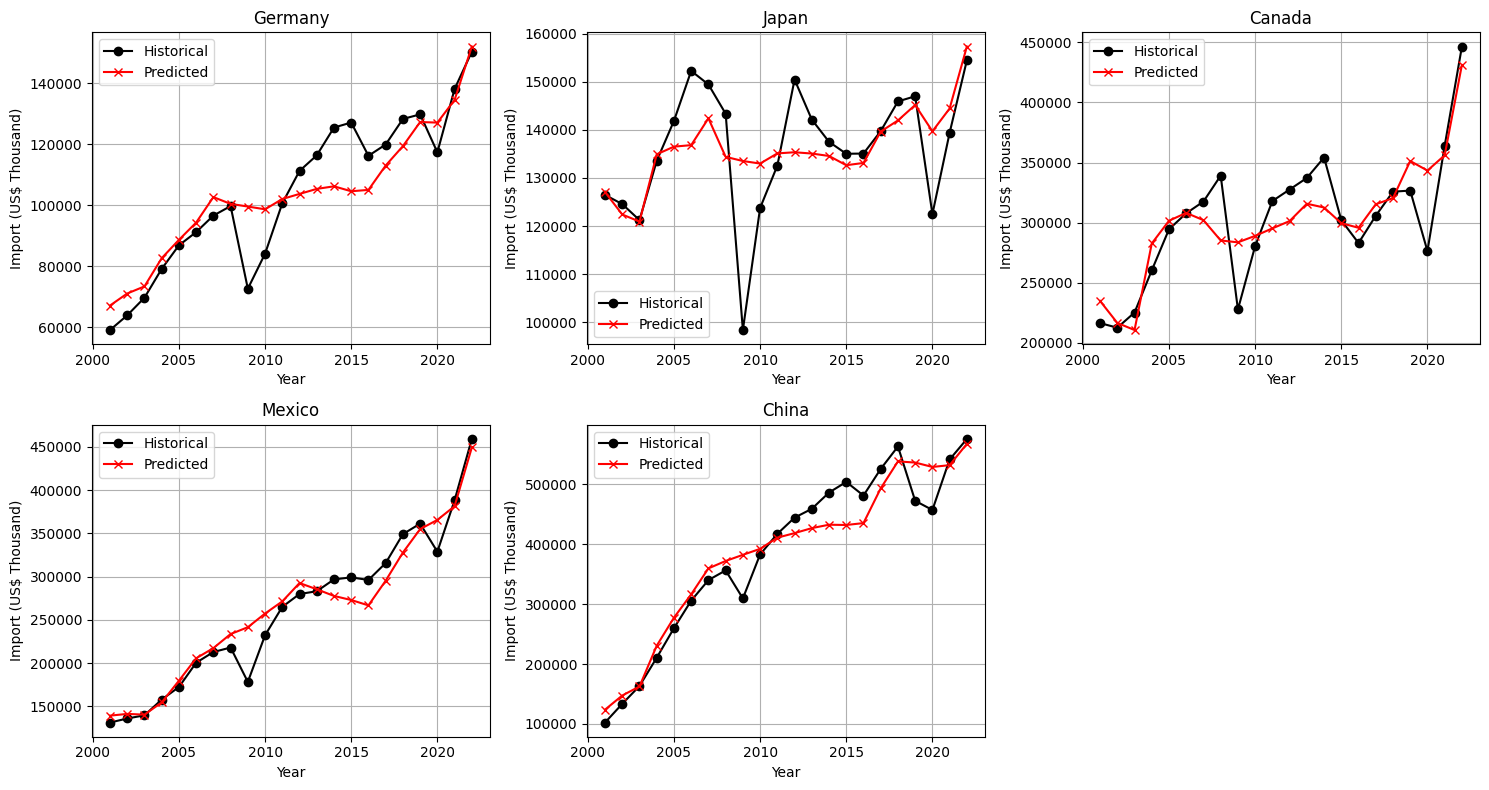

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# -----------------------------
# Parameters
# -----------------------------
top5_countries = ["Germany", "Japan", "Canada", "Mexico", "China"]

# Columns we want to use as predictors (plus 'Lag Import' if desired)
tariff_predictors = [
    "MFN MaxRate (%)",
    "MFN MinRate (%)",
    "MFN Duty Free Tariff Lines Share (%)",
    "MFN Specific Tariff Lines Share (%)",
    "MFN AVE Tariff Lines Share (%)"
]
use_lag_import = True  # Set to False if you do not want to include a lag predictor

# -----------------------------
# Load Data
# -----------------------------

# Filter to "All Products" only (if desired)
all_products_df = main_df[main_df["Product Group"] == "All Products"].copy()

# Create subplots for 5 countries (2 rows x 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=False)
axes = axes.flatten()

# We'll only need 5 subplots; the 6th can remain empty or be turned off
for i, country in enumerate(top5_countries):
    ax = axes[i]

    # -----------------------------
    # Subset for this country
    # -----------------------------
    df_country = all_products_df[all_products_df["Country"] == country].copy()

    # Sort by year and drop rows with missing import values
    df_country = df_country.sort_values("Year").dropna(subset=["Import (US$ Thousand)"])

    # Optionally create a lagged import column
    if use_lag_import:
        df_country["Lag Import"] = df_country["Import (US$ Thousand)"].shift(1)
        df_country = df_country.dropna(subset=["Lag Import"])

    # Define the predictors list (add 'Lag Import' if using it)
    if use_lag_import:
        predictors = tariff_predictors + ["Lag Import"]
    else:
        predictors = tariff_predictors

    # Drop rows missing any predictor
    df_country = df_country.dropna(subset=predictors)

    # -----------------------------
    # Fit the Model
    # -----------------------------
    X = df_country[predictors]
    y = df_country["Import (US$ Thousand)"]

    if len(X) < 2:
        # Not enough data points to train a meaningful model
        ax.set_title(f"{country} (Insufficient Data)")
        continue

    model = LinearRegression()
    model.fit(X, y)

    # -----------------------------
    # In-Sample Simulation
    # -----------------------------
    # We'll predict year by year, recursively updating the lag
    years = df_country["Year"].values
    df_country = df_country.reset_index(drop=True)

    predicted_imports = []
    if use_lag_import:
        # Start with the actual lag from the first row
        current_lag = df_country.loc[0, "Lag Import"]
    else:
        current_lag = None  # Not used if no lag predictor

    for idx in range(len(df_country)):
        row = df_country.loc[idx].copy()

        # If using lag, override the row's 'Lag Import' with the 'current_lag'
        if use_lag_import:
            row["Lag Import"] = current_lag

        # Build the predictor vector
        X_row = row[predictors].values.reshape(1, -1)

        # Predict
        y_pred = model.predict(X_row)[0]
        predicted_imports.append(y_pred)

        # Update lag for next iteration
        if use_lag_import:
            current_lag = y_pred

    df_country["Predicted Import"] = predicted_imports

    # -----------------------------
    # Plot Historical vs. Predicted
    # -----------------------------
    ax.plot(df_country["Year"], df_country["Import (US$ Thousand)"],
            marker='o', color='black', label='Historical')
    ax.plot(df_country["Year"], df_country["Predicted Import"],
            marker='x', color='red', label='Predicted')
    ax.set_title(country)
    ax.set_xlabel("Year")
    ax.set_ylabel("Import (US$ Thousand)")
    ax.grid(True)
    ax.legend()

# Hide the 6th subplot if you only have 5 countries
axes[-1].axis('off')

plt.tight_layout()
plt.show()



=== Germany ===
  Best polynomial degree: 2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist

ValueError: Input X contains infinity or a value too large for dtype('float64').

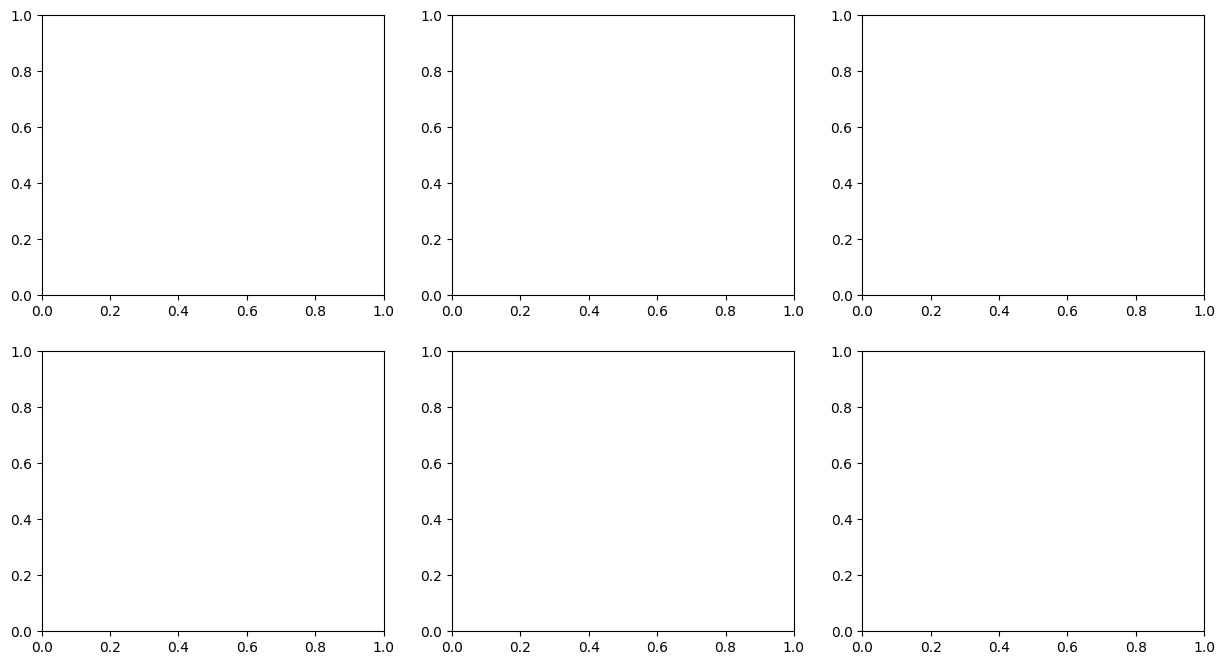

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline

# -----------------------------
# Helper Functions
# -----------------------------

def prepare_country_data(df, country, predictors, use_lag=True):
    """
    Filters the dataframe for a single country, sorts by year,
    and optionally creates a lagged import column.

    Parameters:
    -----------
    df : pd.DataFrame
        Main dataset containing 'Year', 'Import (US$ Thousand)', and tariff columns.
    country : str
        The partner country's name to filter.
    predictors : list of str
        Columns to be used as predictors (excluding 'Lag Import').
    use_lag : bool
        Whether to include a lagged import predictor.

    Returns:
    --------
    df_country : pd.DataFrame
        Processed dataframe for the given country.
    final_predictors : list of str
        Predictors used in the final model (including 'Lag Import' if requested).
    """
    # Filter data for the specified country
    df_country = df[df["Country"] == country].copy()

    # Sort by Year and drop missing import values
    df_country = df_country.sort_values("Year").dropna(subset=["Import (US$ Thousand)"])

    # Optionally create a lagged import column
    if use_lag:
        df_country["Lag Import"] = df_country["Import (US$ Thousand)"].shift(1)
        df_country = df_country.dropna(subset=["Lag Import"])
        final_predictors = predictors + ["Lag Import"]
    else:
        final_predictors = predictors

    # Drop rows missing any predictor
    df_country = df_country.dropna(subset=final_predictors)

    return df_country, final_predictors


def time_series_cv_train_poly(X, y, degree_options=None, n_splits=3):
    """
    Trains a LinearRegression model with PolynomialFeatures using
    time-series cross-validation and GridSearchCV over different polynomial degrees.

    Parameters:
    -----------
    X : pd.DataFrame
        Predictor matrix.
    y : pd.Series
        Target vector.
    degree_options : list of int
        Polynomial degrees to try (e.g., [1, 2, 3]).
    n_splits : int
        Number of splits for time-series cross-validation.

    Returns:
    --------
    best_model : Pipeline
        The best pipeline (PolynomialFeatures + LinearRegression) found by GridSearchCV.
    best_degree : int
        The degree of the best polynomial transformation.
    """
    if degree_options is None:
        degree_options = [1, 2, 3]  # You can adjust as needed

    # Create a pipeline: PolynomialFeatures -> LinearRegression
    pipeline = Pipeline([
        ("poly", PolynomialFeatures(include_bias=False)),  # degree set via param_grid
        ("linreg", LinearRegression())
    ])

    # Time-series split
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Parameter grid for polynomial degree
    param_grid = {
        "poly__degree": degree_options
    }

    # Grid search
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",
        cv=tscv
    )

    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    best_degree = grid_search.best_params_["poly__degree"]
    print(f"  Best polynomial degree: {best_degree}")
    return best_model, best_degree


def in_sample_simulation(df_country, model, predictors, use_lag=True):
    """
    Performs an in-sample simulation (recursive prediction) to compare
    predicted imports with historical data.

    Parameters:
    -----------
    df_country : pd.DataFrame
        Country-specific data sorted by Year, containing columns for
        'Import (US$ Thousand)' and the predictor columns.
    model : Pipeline
        A trained pipeline with PolynomialFeatures + LinearRegression.
    predictors : list of str
        Column names to use for prediction (including 'Lag Import' if used).
    use_lag : bool
        Whether the model expects a lagged import predictor.

    Returns:
    --------
    df_country : pd.DataFrame
        Same dataframe but with an additional 'Predicted Import' column
        containing in-sample simulated predictions.
    """
    df_country = df_country.reset_index(drop=True)

    predicted_imports = []

    # Initialize the lag with the actual first row's "Lag Import" if using lag
    if use_lag:
        current_lag = df_country.loc[0, "Lag Import"]
    else:
        current_lag = None

    for i in range(len(df_country)):
        row = df_country.loc[i].copy()

        # Overwrite 'Lag Import' with our predicted lag if using recursion
        if use_lag:
            row["Lag Import"] = current_lag

        # Build the predictor vector
        X_row = row[predictors].values.reshape(1, -1)

        # Predict
        y_pred = model.predict(X_row)[0]
        predicted_imports.append(y_pred)

        # Update lag for the next iteration
        if use_lag:
            current_lag = y_pred

    df_country["Predicted Import"] = predicted_imports
    return df_country


def plot_country(ax, df_country, country):
    """
    Plots historical vs. predicted imports for a single country on a given axis.

    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axis object to plot on.
    df_country : pd.DataFrame
        Dataframe with columns 'Year', 'Import (US$ Thousand)', 'Predicted Import'.
    country : str
        Name of the country for labeling.
    """
    ax.plot(df_country["Year"], df_country["Import (US$ Thousand)"],
            marker='o', color='black', label='Historical')
    ax.plot(df_country["Year"], df_country["Predicted Import"],
            marker='x', color='red', label='Predicted')
    ax.set_title(country)
    ax.set_xlabel("Year")
    ax.set_ylabel("Import (US$ Thousand)")
    ax.grid(True)
    ax.legend()

# -----------------------------
# Main Workflow
# -----------------------------
if __name__ == "__main__":

    # Filter for "All Products" if you only want aggregated product data
    all_products_df = main_df[main_df["Product Group"] == "All Products"].copy()

    # Define your top 5 countries (example)
    top5_countries = ["Germany", "Japan", "Canada", "Mexico", "China"]

    # Columns we want to use as predictors (excluding lag for now)
    tariff_predictors = [
        "MFN MaxRate (%)",
        "MFN MinRate (%)",
        "MFN Duty Free Tariff Lines Share (%)",
        "MFN Specific Tariff Lines Share (%)",
        "MFN AVE Tariff Lines Share (%)"
    ]
    use_lag_import = True  # Decide if you want to include the lag feature

    # Create subplots for 5 countries (2 rows x 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=False)
    axes = axes.flatten()

    # We'll only use 5 subplots; the 6th is extra
    for i, country in enumerate(top5_countries):
        ax = axes[i]

        print(f"\n=== {country} ===")
        # 1) Prepare the data
        df_country, final_predictors = prepare_country_data(
            all_products_df,
            country,
            tariff_predictors,
            use_lag=use_lag_import
        )

        # If there's not enough data to train, skip
        if len(df_country) < 2:
            ax.set_title(f"{country} (Insufficient Data)")
            ax.axis('off')
            continue

        # 2) Separate X, y
        X = df_country[final_predictors]
        y = df_country["Import (US$ Thousand)"]

        # 3) Train model with polynomial features + linear regression
        #    using time-series cross-validation
        best_model, best_degree = time_series_cv_train_poly(X, y, degree_options=[2, 3, 4], n_splits=3)

        # 4) In-sample simulation
        df_country_sim = in_sample_simulation(df_country, best_model, final_predictors, use_lag=use_lag_import)

        # 5) Plot
        plot_country(ax, df_country_sim, country)
        ax.set_title(f"{country} (Degree={best_degree})")

    # Hide the extra subplot
    axes[-1].axis('off')

    plt.tight_layout()
    plt.show()